In [1]:
import pandas as pd
import geopandas as gpd
from osgeo import osr, gdal
import matplotlib.pyplot as plt
import numpy as np

/Users/ngochoang/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
vlm = pd.read_excel('data.xls')

In [3]:
vlm

,Station,Longitude,Latitude,VLM,VLM_std
0,NYWV,54.684594,24.796595,-0.207,0.223
1,NYWT,54.115618,24.303783,1.413,0.158
2,NYSM,53.848164,24.056855,-0.856,0.154
3,NYRH,53.141386,24.147625,-0.724,0.166
4,NYRB,52.587928,24.171598,1.812,0.274
5,NYQN,52.763306,24.027073,-0.724,0.135
6,NYPD,53.470797,23.925228,2.240,0.164
7,NYPB,54.162907,24.134528,2.164,0.162
8,NYON,54.429235,24.539444,-0.683,0.170
9,NYNB,54.319712,24.460688,-0.259,0.255


In [4]:
elevation = gdal.Open('Elevation.tif', gdal.GA_ReadOnly)

In [5]:
elev_arr = elevation.GetRasterBand(1).ReadAsArray()
elev_arr

array([[32767, 32767, 32767, ...,    -2,    -4,    -4],
       [32767, 32767, 32767, ...,    -3,    -4,    -6],
       [32767, 32767, 32767, ...,    -3,    -4,    -4],
       ...,
       [32767, 32767, 32767, ...,    39,    38,    38],
       [32767, 32767, 32767, ...,    38,    39,    40],
       [32767, 32767, 32767, ...,    37,    38,    39]], dtype=int16)

In [6]:
def visualize_raster_bands(dataset):
    """
    Iterates through all raster bands of a dataset
    and makes plots.
    Args:
        dataset: GDALDataset object
    
    Returns:
        [PLACEHOLDER]
    """
    raster_count = dataset.RasterCount
    # Iterate from band #1 to band #raster_count
    bands = []
    for i in range(1, raster_count+1):
        band = dataset.GetRasterBand(i)
        bands.append(band)
    arrs = [band.ReadAsArray() for band in bands]
    fig, axs = plt.subplots(1, raster_count, figsize=(8*raster_count, 8))
    for i in range(raster_count):
        if raster_count > 1:
            axs[i].imshow(arrs[i], cmap='GnBu')
            axs[i].set_title(f"Band #{i+1}")
        else:
            plt.imshow(arrs[0])
            plt.title(f"Band #1")
    plt.show()

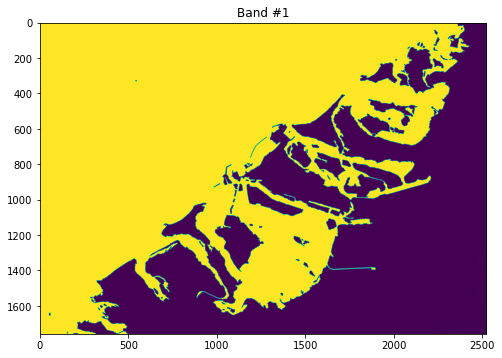

In [7]:
visualize_raster_bands(elevation)

In [8]:
gt = elevation.GetGeoTransform()
if gt:
    print("Origin = ({}, {})".format(gt[0], gt[3]))
    print("Pixel Size = ({}, {})".format(gt[1], gt[5]))

Origin = (53.99986135, 24.700138706)
Pixel Size = (0.00027777780000000054, -0.0002777777999999998)


In [9]:
old_cs = osr.SpatialReference()

In [10]:
old_cs.ImportFromWkt(elevation.GetProjectionRef())

0

In [11]:
elevation.GetProjectionRef()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [12]:
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()
new_cs.ImportFromWkt(wgs84_wkt)

0

GT(0) x-coordinate of the upper-left corner of the upper-left pixel.

GT(1) w-e pixel resolution / pixel width.

GT(2) row rotation (typically zero).

GT(3) y-coordinate of the upper-left corner of the upper-left pixel.

GT(4) column rotation (typically zero).

GT(5) n-s pixel resolution / pixel height (negative value for a north-up image).

In [13]:
transform = osr.CoordinateTransformation(old_cs, new_cs)

In [14]:
width = elevation.RasterXSize
height = elevation.RasterYSize
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5]

In [15]:
(width, height), (minx, miny)

((2521, 1758), (53.99986135, 24.2118053336))

In [16]:
latlong = transform.TransformPoint(minx, miny)

In [17]:
latlong

(53.99986135, 24.2118053336, 0.0)

In [18]:
import georasters as gr

In [19]:
file = 'Elevation.tif'

In [20]:
data = gr.from_file(file)

<AxesSubplot:>

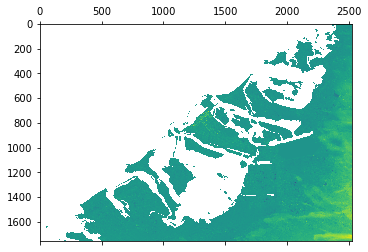

In [21]:
data.plot()

In [22]:
df = data.to_pandas()
df

,row,col,value,x,y
0,0,2347,1.0,54.651806,24.700139
1,0,2348,0.0,54.652084,24.700139
2,0,2349,1.0,54.652361,24.700139
3,0,2350,1.0,54.652639,24.700139
4,0,2351,2.0,54.652917,24.700139
...,...,...,...,...,...
1789656,1757,2516,37.0,54.698750,24.212083
1789657,1757,2517,36.0,54.699028,24.212083
1789658,1757,2518,37.0,54.699306,24.212083
1789659,1757,2519,38.0,54.699584,24.212083


In [23]:
df.x.min(), df.x.max()

(54.01375024, 54.699861406000004)

In [24]:
df.y.min(), df.y.max()

(24.212083111400002, 24.700138706)

In [25]:
vlm.Longitude.min()

52.587928

In [26]:
new_vlm = vlm.drop(columns=["Station", "VLM_std"], axis=1)

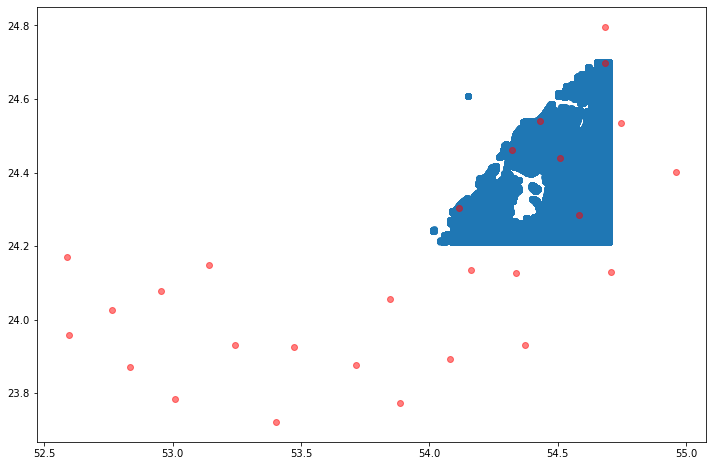

In [27]:
plt.figure(figsize=(12, 8))
plt.scatter(df.x, df.y, alpha=0.5)
plt.scatter(vlm.Longitude, vlm.Latitude, color='r', alpha=0.5)
# plt.scatter(52.587928, 24.171598, color='g')
# plt.scatter(53.402955, 23.721481, color='g')
plt.show()